In [57]:
import json
import os
import pprint

class digest_query:
    def __init__(self, query_id, digest, digest_text, time_ms, cpu_usage, timestamp):
        self.query_id = query_id
        self.digest = digest
        self.digest_text = digest_text
        self.value = [(timestamp, time_ms, cpu_usage)]
        self.time_ms = []
        self.cpu_usage = []
        self.timestamp = []
    
    def add_timestamp(self, time_ms, cpu_usage, timestamp):
        self.value.append((timestamp, time_ms, cpu_usage))
    
    def print_digest_query(self):
        print(f'query_id={self.query_id}')
        print(f'digest={self.digest}')
        print(f'digest_text={self.digest_text}')
        print(f'time_ms={self.time_ms}')
        print(f'cpu_usage={self.cpu_usage}')
    
    def sort_timestamp(self):
        self.value = list(map(lambda x: (x[0], float(x[1]), float(x[2])), self.value))
        self.value = sorted(self.value, key=lambda x:x[0])
        for v in self.value:
            self.time_ms.append(v[1]) 
            self.cpu_usage.append(v[2])
            self.timestamp.append(v[0])

dict = {}
query_num = 0

for filename in os.listdir("/root/db_agent/data"):
   with open(os.path.join("/root/db_agent/data", filename), 'r') as f:
       text = json.load(f)
       #print(text)
       #print(type(text))
       performance_schema = text['metrics_data']['global']['performance_schema']
       #print(metrics_data)
       threads = performance_schema['threads']       
       tid_dict = {i[0]['thread_id']:i[0]['thread_os_id'] for i in threads}
       #print(tid_dict)
    #{ key:val for key,val in fruit_color.items() if key != "banana" }
       cpu_usage = performance_schema['cpu_usage'] # thread_os_id : cpu_usage
       #print(cpu_usage)
       events_statements_history = performance_schema['events_statements_history']

       for event in events_statements_history:
        digest = event['digest']
        if digest is None:
            continue
        #print(type(digest))
        thread_id = event['thread_id']
        digest_text = event['digest_text']
        if digest in dict.keys():
            dict[digest].add_timestamp(event['time_ms'], cpu_usage[str(tid_dict[thread_id])], filename)
        else:
            temp = digest_query(query_num, digest, digest_text, event['time_ms'], cpu_usage[str(tid_dict[thread_id])], filename)
            dict[digest] = temp
            query_num+=1


       
       #print(threads)
       
       
       #print(events_statements_history)
#for query in dict:
#    dict[query].print_digest_query()

       

# digest가 이미 존재
# dict[digest]에 정보들을 추가
# digest가 이미 존재하지 않음
# 새로 추가. key-digest value-object

# digest는 key
# digest_query class를 만들자
# Class digest_query
# digest, digest_text, cpu-usage = list[(timestamp, value)], time_ms = list[(timestamp, value)]
# (timestamp-filename)
# digest, digest_text는 events 받은 것으로부터 얻을 수 있다. 
# digest, time_ms, thread_id,  



In [58]:
def Average(lst):
    return sum(lst) / len(lst)

rank_list = []
for query in dict:
    dict[query].sort_timestamp()
    rank_list.append((dict[query].query_id, Average(dict[query].time_ms), Average(dict[query].cpu_usage)))

time_top5 = sorted(rank_list, key=lambda x:-x[1])[:5]
cpu_top5 = sorted(rank_list, key=lambda x:-x[2])[:5]

time_top5_qid = [i[0] for i in time_top5]
cpu_top5_qid = [i[0] for i in cpu_top5]

print(time_top5_qid)
print(cpu_top5_qid)

[44, 50, 2, 34, 15]
[43, 50, 48, 38, 23]


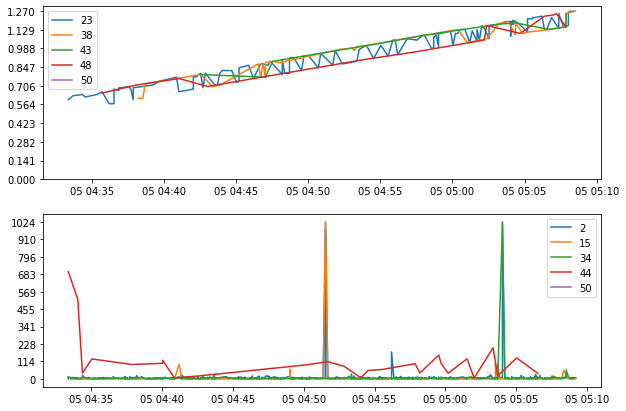

In [59]:
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np

#plt.figure(figsize=(10, 7))#, default: rcParams["figure.figsize"]
fig, axs = plt.subplots(2, figsize=(10, 7))
y1_max=0
y2_max=0
for query in dict:
    #dict[query].print_digest_query()
    if dict[query].query_id in time_top5_qid:
        x = [dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in dict[query].timestamp]
        y2 = list(map(float, dict[query].time_ms))
        axs[1].plot(x,y2, label=dict[query].query_id)
        y2_max = max(y2_max, max(y2))
    
    if dict[query].query_id in cpu_top5_qid:
        x = [dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in dict[query].timestamp]
        y1 = list(map(float, dict[query].cpu_usage))
        y1_max = max(y1_max, max(y1))
        axs[0].plot(x,y1, label=dict[query].query_id)
    #plt.plot(x,y, label=dict[query].query_id)
    
    #break

axs[0].set_yticks(np.linspace(0,y1_max,10))
axs[0].legend()
axs[1].set_yticks(np.linspace(0,y2_max,10))
axs[1].legend()



#plt.legend()
plt.show()

In [34]:
import subprocess

# proc = subprocess.Popen(
#     ['ps -ef | grep mysql'],
#     stdout=subprocess.PIPE
#     )
# out, err = proc.communicate()
# print(out)
# print(out.decode('utf-8'))

ps_result = subprocess.check_output(['ps -ef | grep mysql'], shell=True).decode()


ps_lines = ps_result.splitlines()
TID = []
for ps_line in ps_lines:
    ps_line=ps_line.replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ')
    ps = ps_line.split(' ')
    if 'mysql' in ps[0]:
        TID.append(ps[1])

print(TID)
# result = subprocess.check_output(['pidstat', '-t']).decode()
# #len (result.splitlines()) 
# result.splitlines()
# lines = result.splitlines()[3:]
# dict={}
# for line in lines:
#     line=line.replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ')
#     words = line.split(' ')
#     # TID = words[3]
#     # %cpu = words[8]
#     if words[3] =='-':
#         continue
#     dict[words[3]] = words[8]

# sorted(dict.items(),key=lambda x:x[1],reverse=True)


['52846', '52993']


In [41]:
import pprint

In [20]:
"""Tests for interacting with MySQL database"""
import json
import time

from typing import Dict, Any, Union
import mysql.connector

from driver.collector.collector_factory import get_mysql_version, connect_mysql
from driver.database import (
    collect_db_level_data_from_database,
    collect_table_level_data_from_database,
)
from tests.useful_literals import TABLE_LEVEL_MYSQL_COLUMNS

# pylint: disable=ungrouped-imports
from driver.collector.mysql_collector import MysqlCollector

# pylint: disable=missing-function-docstring


In [24]:
def _db_query(conn: mysql.connector.MySQLConnection, sql: str) -> None:
    conn.cursor().execute(sql)


def _create_user(
    conn: mysql.connector.MySQLConnection, user: str, password: str
) -> None:
    sql = f"CREATE USER IF NOT EXISTS '{user}' IDENTIFIED BY '{password}';"
    _db_query(conn, sql)


def _drop_user(conn: mysql.connector.MySQLConnection, user: str) -> None:
    sql = f" DROP USER IF EXISTS '{user}';"
    _db_query(conn, sql)


def _get_conf(
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
) -> Dict[str, str]:
    conf = {
        "user": mysql_user,
        "password": mysql_password,
        "host": mysql_host,
        "port": mysql_port,
        "database": mysql_database,
    }
    return conf


def _get_driver_conf(
    db_type: str,
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
    num_table_to_collect_stats: int,
    num_index_to_collect_stats: int,
) -> Dict[str, Union[int, str]]:
    # pylint: disable=too-many-arguments
    conf = {
        "db_user": mysql_user,
        "db_password": mysql_password,
        "db_host": mysql_host,
        "db_port": mysql_port,
        "db_name": mysql_database,
        "db_type": db_type,
        "db_provider": "on_premise",
        "db_key": "test_key",
        "organization_id": "test_organization",
        "num_table_to_collect_stats": num_table_to_collect_stats,
        "num_index_to_collect_stats": num_index_to_collect_stats,
    }
    return conf



In [25]:
db_type='mysql'
mysql_host='127.0.0.1'
mysql_port='3306'
mysql_user='root'
mysql_password='1234'
mysql_database=''

driver_conf = _get_driver_conf(
        db_type, mysql_user, mysql_password, mysql_host, mysql_port, mysql_database, 10, 100
    )
observation = collect_db_level_data_from_database(driver_conf)
knobs = observation["knobs_data"]
metrics = observation["metrics_data"]
summary = observation["summary"]
row_num_stats = observation["row_num_stats"]
version_str = summary["version"]

#pprint.pprint(observation)

conf = _get_conf(mysql_user, mysql_password, mysql_host, mysql_port, mysql_database)
conn = connect_mysql(conf)
version = get_mysql_version(conn)
collector_2 = MysqlCollector(conn, version)
collector_2.collect_test()



conn.close()



{'host': '127.0.0.1', 'port': '3306', 'user': 'root', 'password': '1234', 'charset': 'utf8', 'database': 'information_schema'}


MysqlCollectorException: Failed to connect to MySQL, caused by <class 'mysql.connector.errors.ProgrammingError'>: 1045 (28000): Access denied for user 'root'@'localhost' (using password: YES)

In [ ]:
def test_mysql_collector_version(
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
) -> None:
    conf = _get_conf(mysql_user, mysql_password, mysql_host, mysql_port, mysql_database)
    conn = connect_mysql(conf)
    version = get_mysql_version(conn)
    collector = MysqlCollector(conn, version)
    conn.close()
    assert collector.get_version() == version

def test_mysql_collector_permission_success(
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
) -> None:
    conf = _get_conf(mysql_user, mysql_password, mysql_host, mysql_port, mysql_database)
    conn = connect_mysql(conf)
    version = get_mysql_version(conn)
    collector = MysqlCollector(conn, version)
    perm_res = collector.check_permission()
    conn.close()
    assert perm_res[1] == []
    assert perm_res[0] is True

def test_mysql_collector_permission_failed(
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
) -> None:
    conf = _get_conf(mysql_user, mysql_password, mysql_host, mysql_port, mysql_database)
    conn = connect_mysql(conf)
    version = get_mysql_version(conn)
    new_user = "ot_test_user"
    new_password = "ot_test_password"
    # additional permissions are not granted for a new test user
    _create_user(conn, new_user, new_password)
    new_conf = _get_conf(new_user, new_password, mysql_host, mysql_port, mysql_database)
    new_conn = connect_mysql(new_conf)
    version = get_mysql_version(conn)
    new_collector = MysqlCollector(new_conn, version)
    perm_res = new_collector.check_permission()

    # drop the test user
    _drop_user(conn, new_user)
    conn.close()
    assert len(perm_res[1]) > 0
    assert perm_res[0] is False

def _verify_mysql_knobs(knobs: Dict[str, Any]) -> None:
    assert int(knobs["global"]["global"]["innodb_buffer_pool_size"]) >= 0
    assert knobs["local"] is None

def test_mysql_collector_knobs(
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
) -> None:
    conf = _get_conf(mysql_user, mysql_password, mysql_host, mysql_port, mysql_database)
    conn = connect_mysql(conf)
    version = get_mysql_version(conn)
    collector = MysqlCollector(conn, version)
    knobs = collector.collect_knobs()
    conn.close()
    # the knob json should not contain any field that cannot be converted to a string,
    # like decimal type and datetime type
    json.dumps(knobs)
    _verify_mysql_knobs(knobs)

def _verify_mysql_metrics(metrics: Dict[str, Any], version_str: str) -> None:
    version = float(".".join(version_str.split(".")[:2]))
    assert int(metrics["global"]["global"]["com_insert"]) >= 0
    assert metrics["global"]["innodb_metrics"]["trx_rw_commits"] >= 0
    assert metrics["global"]["engine"]["innodb_status"] is not None
    assert metrics["global"]["engine"]["replica_status"] is not None
    assert metrics["global"]["engine"]["master_status"] is not None
    latency_hist = metrics["global"]["performance_schema"].get(
        "events_statements_histogram_global"
    )
    if version >= 8:  # events histogram is supported since mysql 8
        assert latency_hist is not None
    else:
        assert latency_hist is None
    assert metrics["local"] is None


def test_mysql_collector_metrics(
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
) -> None:
    conf = _get_conf(mysql_user, mysql_password, mysql_host, mysql_port, mysql_database)
    conn = connect_mysql(conf)
    version_str = get_mysql_version(conn)
    collector = MysqlCollector(conn, version_str)
    metrics = collector.collect_metrics()
    conn.close()
    # the metric json should not contain any field that cannot be converted to a string,
    # like decimal type and datetime type
    json.dumps(metrics)
    _verify_mysql_metrics(metrics, version_str)


def test_collect_data_from_database(
    db_type: str,
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
) -> None:
    # pylint: disable=too-many-arguments
    driver_conf = _get_driver_conf(
        db_type, mysql_user, mysql_password, mysql_host, mysql_port, mysql_database, 10, 100
    )
    observation = collect_db_level_data_from_database(driver_conf)
    knobs = observation["knobs_data"]
    metrics = observation["metrics_data"]
    summary = observation["summary"]
    row_num_stats = observation["row_num_stats"]
    version_str = summary["version"]
    _verify_mysql_knobs(knobs)
    _verify_mysql_metrics(metrics, version_str)
    assert summary["observation_time"] > 0
    assert len(version_str) > 0
    # mysql not implemented
    assert row_num_stats == {}


def test_mysql_collect_row_stats(
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
) -> None:
    conf = _get_conf(mysql_user, mysql_password, mysql_host, mysql_port, mysql_database)
    conn = connect_mysql(conf)
    version = get_mysql_version(conn)
    collector = MysqlCollector(conn, version)
    row_stats = collector.collect_table_row_number_stats()
    conn.close()
    assert row_stats == {}


def _verify_mysql_table_level_data(data: Dict[str, Any], table_nums: int) -> None:
    assert data["information_schema_TABLES"]["columns"] == TABLE_LEVEL_MYSQL_COLUMNS
    assert len(data["information_schema_TABLES"]["rows"]) == table_nums
    for row in data["information_schema_TABLES"]["rows"]:
        assert len(row) == len(TABLE_LEVEL_MYSQL_COLUMNS)


def test_collect_table_level_data_from_database(
    db_type: str,
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
) -> None:
    # pylint: disable=too-many-arguments
    num_table_to_collect_stats = 10
    num_index_to_collect_stats = 10

    conf = _get_conf(mysql_user, mysql_password, mysql_host, mysql_port, mysql_database)
    conn = connect_mysql(conf)
    _db_query(conn, "DROP DATABASE IF EXISTS testdb;")

    driver_conf = _get_driver_conf(
        db_type,
        mysql_user,
        mysql_password,
        mysql_host,
        mysql_port,
        mysql_database,
        num_table_to_collect_stats,
        num_index_to_collect_stats
    )
    observation = collect_table_level_data_from_database(driver_conf)
    data = observation["data"]
    summary = observation["summary"]
    version_str = summary["version"]
    assert summary["observation_time"] > 0
    assert len(version_str) > 0
    # 0 as the database is empty
    _verify_mysql_table_level_data(data, 0)


def test_mysql_collect_table_level_metrics(
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
) -> None:
    num_table_to_collect_stats = 10
    num_index_to_collect_stats = 100
    conf = _get_conf(mysql_user, mysql_password, mysql_host, mysql_port, mysql_database)
    conn = connect_mysql(conf)
    _db_query(conn, "DROP DATABASE IF EXISTS testdb;")

    version = get_mysql_version(conn)
    collector = MysqlCollector(conn, version)
    target_table_info = collector.get_target_table_info(num_table_to_collect_stats)
    metrics = collector.collect_table_level_metrics(target_table_info)
    metrics.update(collector.collect_index_metrics(target_table_info, num_index_to_collect_stats))

    # the metric json should not contain any field that cannot be converted to a string,
    # like decimal type and datetime type
    json.dumps(metrics)

    _verify_mysql_table_level_data(metrics, 0)


def test_mysql_collect_index_metrics(
    mysql_user: str,
    mysql_password: str,
    mysql_host: str,
    mysql_port: str,
    mysql_database: str,
) -> None:
    num_table_to_collect_stats = 10
    num_index_to_collect_stats = 100
    conf = _get_conf(mysql_user, mysql_password, mysql_host, mysql_port, mysql_database)
    conn = connect_mysql(conf)

    _db_query(conn, "DROP DATABASE IF EXISTS testdb;")
    _db_query(conn, "CREATE DATABASE testdb;")
    _db_query(conn, "USE testdb;")
    _db_query(conn, "CREATE TABLE IF NOT EXISTS test1 "
                    "(id MEDIUMINT NOT NULL AUTO_INCREMENT, "
                    "num INTEGER, data VARCHAR(30), PRIMARY KEY(id));")
    _db_query(conn, "INSERT IGNORE INTO test1(id, num, data) values (1, 2, 'abc');")
    _db_query(conn, "ALTER TABLE test1 ADD INDEX idx_test1(num);")

    time.sleep(1)
    version = get_mysql_version(conn)
    collector = MysqlCollector(conn, version)
    target_table_info = collector.get_target_table_info(num_table_to_collect_stats)
    metrics = collector.collect_index_metrics(target_table_info, num_index_to_collect_stats)

    assert metrics["indexes_size"]["rows"][1][2] == "idx_test1"
